In [193]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import struct
import numpy as np
import numpy.linalg as LA

# 課題1（PCA）

In [194]:
### MNISTデータベース読み込み関数
### 参考: [第3版]Python機械学習プログラミング, インプレス
def load_mnist(path, kind='train'):
    """MNISTデータをpathからロード"""
    # 引数に指定したパスを結合
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    
    # ファイルを読み込む
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換: unpack関数の引数にフォーマット、8bytes分の
        # バイナリデータを指定してマジックナンバー、アイテムの個数を読み込む
        magic, n = struct.unpack('>II', lbpath.read(8))
        # ファイルからラベルを読み込み配列を構築: fromfile関数の引数に
        # ファイル、配列のデータ形式を指定
        labels = np.fromfile(lbpath, dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        # 画像ピクセル情報の配列のサイズを変更（行数：ラベルのサイズ、列数：特徴量の個数）
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels),784)
        images = ((images / 255.) - .5) * 2
    
    return images, labels

### 事前にコードと同じフォルダに(圧縮されていない)データを格納しておく
### 学習ラベルデータ: train-labels-idx1-ubyte
### 学習画像データ: train-images-idx3-ubyte
### 元のデータ: THE MNIST DATABASE of handwritten digits
### http://yann.lecun.com/exdb/mnist/
###
### Xに画像データ, yにラベルデータを読み込む
### 画像データの画素値は [-1,1] に正規化されている
X, y = load_mnist('', kind='train')  # 学習データ60000個の読み込み
X_test, y_test = load_mnist('', kind='t10k')  # テストデータ60000個の読み込み
DIM = X.shape[1] # 画像データの次元 784

In [195]:
### 数字を表示
def show_number(x, title="title"):
    img = x.reshape(28, 28) # 配列を 28 x 28 に変形
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='Greys')
    ax.set_title(title)
    plt.show()

## １．MNIST手書き数字データベースの訓練データを用いて主成分分析を行うプログラムを作成し，以下の結果を示せ

### 主成分分析を実行
データ行列から平均を求め，中心に移動させる  
共分散行列の固有値問題を解き，固有値の大きいものから第一主成分，第二主成分である

In [196]:
X_ave = np.mean(X, axis=0) # 平均
X_data = X - X_ave # データ行列
Sigma = (X_data.T @ X_data) / len(X_data) # データ行列の共分散行列
w, v = np.linalg.eig(Sigma)  # 共分散行列 Sigma の固有値 w , 固有ベクトル v の算出

### 「寄与率」および「累積寄与率」のグラフ
第一主成分から順に寄与率が大きいことが確認できた．

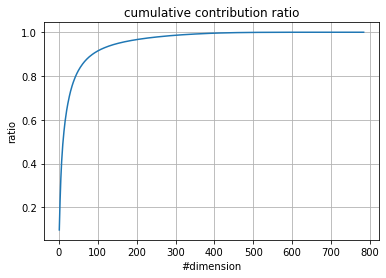

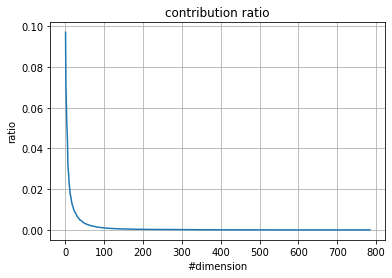

In [197]:
# 全分散量
V_total = np.sum(w)

# 寄与率
c = [w_i/V_total for w_i in w]

# 累積寄与率
r = [w[0]]
for i in range(1, DIM):
    r.append(w[i]+r[-1])
r /= V_total

dim = [i for i in range(1, DIM+1)]

plt.plot(dim, r)
plt.title("cumulative contribution ratio")
plt.xlabel('#dimension')
plt.ylabel('ratio')
plt.grid()
plt.show()

plt.plot(dim, c)
plt.title("contribution ratio")
plt.xlabel('#dimension')
plt.ylabel('ratio')
plt.grid()
plt.show()

### 累積寄与率が「0.90以上」，「0.95以上」，「0.99以上」となる主成分の数

In [198]:
print("dim(99%) = ", np.where(r>=0.99)[0][0])
print("dim(95%) = ", np.where(r>=0.95)[0][0])
print("dim(90%) = ", np.where(r>=0.90)[0][0])

dim(99%) =  330
dim(95%) =  153
dim(90%) =  86


### 上記の主成分数でデータを再構成した例と元データとの比較
累積寄与率が90%, 95%を占める主成分で再構成した場合では，識別可能なレベルに再構成することは出来なかった．
累積寄与率が99%を占める主成分で再構成した場合，識別可能なレベルになった．

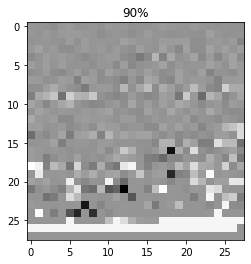

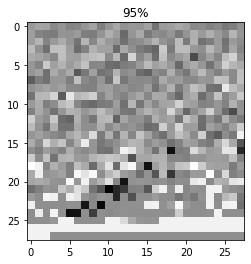

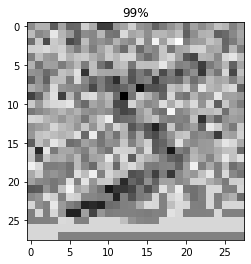

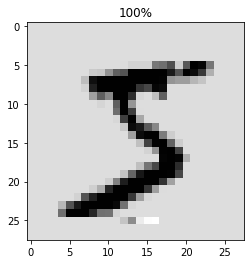

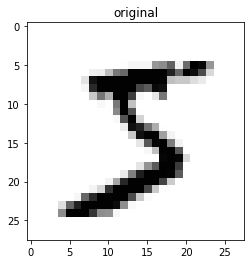

In [199]:
# 射影成分を計算
s = v.dot(X[0])    # 固有ベクトル行列でデータxを線形変換 : p <- v^T  x

# 線形和をとる
x_90 = np.zeros(DIM)
x_95 = np.zeros(DIM)
x_99 = np.zeros(DIM)
x_full = np.zeros(DIM)
for i in range(0, 86):
    x_90 += v[i]*s[i]
for i in range(0, 153):
    x_95 += v[i]*s[i]
for i in range(0, 330):
    x_99 += v[i]*s[i]
for i in range(0, DIM):
    x_full += v[i]*s[i]
    
show_number(x_90, "90%") # 累積寄与率0.90で再構成
show_number(x_95, "95%") # 累積寄与率0.95で再構成
show_number(x_99, "99%") # 累積寄与率0.99で再構成
show_number(x_full, "100%") # 全主成分で再構成
show_number(X[0], "original") # 元データ

## ２．また，訓練データを構築した主成分を使用し，テストデータに対するNMSEを計算するプログラムを作成し，再構成に使用した主成分数を変化させたときのNMSEの計算結果をグラフ化せよ
テストデータに対しても主成分分析を用いて次元削減することが可能であった．  
再構成に使用する主成分数を大きくすると，それに従ってNMSEが減少することが確認できた．

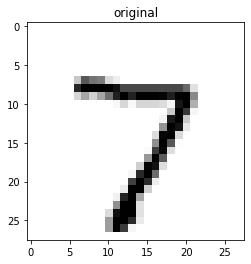

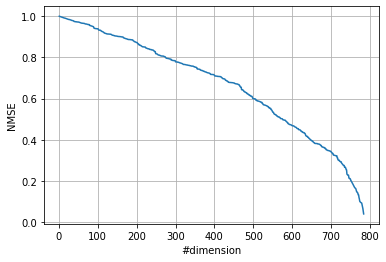

In [200]:
show_number(X_test[0], "original")
# 射影成分を計算
s = v.dot(X_test[0])    # 固有ベクトル行列でデータxを線形変換 : p <- v^T  x

NMSE = []

for i in range(1, DIM+1):
    x_i = np.zeros(DIM)
    for j in range(0, i):
        x_i += v[j]*s[j]
    NMSE.append(np.linalg.norm(x_i-X_test[0], ord=2)/np.linalg.norm(X_test[0], ord=2))

plt.plot(dim, NMSE)
plt.xlabel('#dimension')
plt.ylabel('NMSE')
plt.grid()
plt.show()

# 課題2（PCAの適用）
Fashion-MNISTを使用した．  
参考文献 Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf.  
https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md

In [201]:
### MNISTデータベース読み込み関数
### 参考: [第3版]Python機械学習プログラミング, インプレス
def load_fashion_mnist(path, kind='fashion-train'):
    """MNISTデータをpathからロード"""
    # 引数に指定したパスを結合
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    
    # ファイルを読み込む
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換: unpack関数の引数にフォーマット、8bytes分の
        # バイナリデータを指定してマジックナンバー、アイテムの個数を読み込む
        magic, n = struct.unpack('>II', lbpath.read(8))
        # ファイルからラベルを読み込み配列を構築: fromfile関数の引数に
        # ファイル、配列のデータ形式を指定
        labels = np.fromfile(lbpath, dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        # 画像ピクセル情報の配列のサイズを変更（行数：ラベルのサイズ、列数：特徴量の個数）
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels),784)
        images = ((images / 255.) - .5) * 2
    
    return images, labels

### 事前にコードと同じフォルダに(圧縮されていない)データを格納しておく
### 学習ラベルデータ: train-labels-idx1-ubyte
### 学習画像データ: train-images-idx3-ubyte
### 元のデータ: THE MNIST DATABASE of handwritten digits
### http://yann.lecun.com/exdb/mnist/
###
### Xに画像データ, yにラベルデータを読み込む
### 画像データの画素値は [-1,1] に正規化されている
X, y = load_mnist('', kind='fashion-train')  # 学習データ60000個の読み込み
DIM = X.shape[1] # 画像データの次元 784

In [202]:
### 服画像を表示
def show_fashion(x, title="title"):
    img = x.reshape(28, 28) # 配列を 28 x 28 に変形
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='Greys')
    ax.set_title(title)
    plt.show()

### 主成分分析を実行

In [203]:
X_ave = np.mean(X, axis=0) # 平均
X_data = X - X_ave # データ行列
Sigma = (X_data.T @ X_data) / len(X_data) # データ行列の共分散行列
w, v = np.linalg.eig(Sigma)  # 共分散行列 Sigma の固有値 w , 固有ベクトル v の算出

### 「寄与率」および「累積寄与率」のグラフ

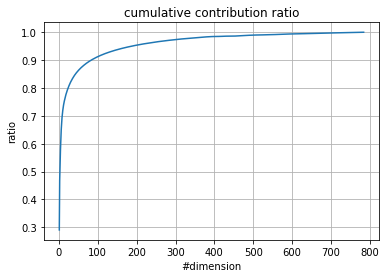

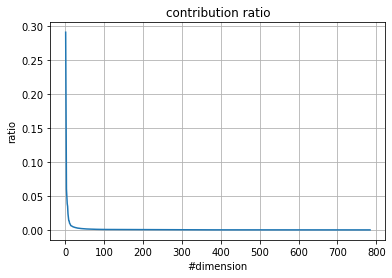

In [204]:
# 全分散量
V_total = np.sum(w)

# 寄与率
c = [w_i/V_total for w_i in w]

# 累積寄与率
r = [w[0]]
for i in range(1, DIM):
    r.append(w[i]+r[-1])
r /= V_total

dim = [i for i in range(1, DIM+1)]

plt.plot(dim, r)
plt.title("cumulative contribution ratio")
plt.xlabel('#dimension')
plt.ylabel('ratio')
plt.grid()
plt.show()

plt.plot(dim, c)
plt.title("contribution ratio")
plt.xlabel('#dimension')
plt.ylabel('ratio')
plt.grid()
plt.show()

### 累積寄与率が「0.90以上」，「0.95以上」，「0.99以上」となる主成分の数

In [205]:
print("dim(99%) = ", np.where(r>=0.99)[0][0])
print("dim(95%) = ", np.where(r>=0.95)[0][0])
print("dim(90%) = ", np.where(r>=0.90)[0][0])

dim(99%) =  505
dim(95%) =  186
dim(90%) =  83


### 上記の主成分数でデータを再構成した例と元データとの比較

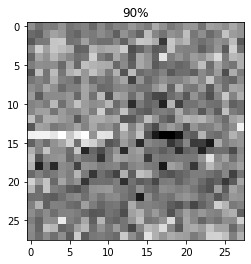

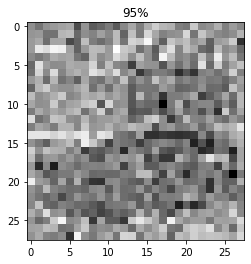

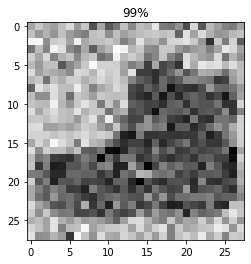

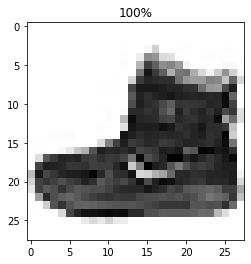

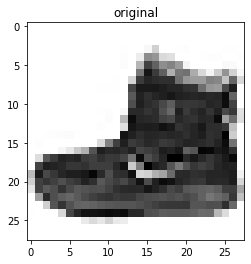

In [206]:
# 射影成分を計算
s = v.dot(X[0])    # 固有ベクトル行列でデータxを線形変換 : p <- v^T  x

# 線形和をとる
x_90 = np.zeros(DIM)
x_95 = np.zeros(DIM)
x_99 = np.zeros(DIM)
x_full = np.zeros(DIM)
for i in range(0, 83):
    x_90 += v[i]*s[i]
for i in range(0, 186):
    x_95 += v[i]*s[i]
for i in range(0, 505):
    x_99 += v[i]*s[i]
for i in range(0, DIM):
    x_full += v[i]*s[i]
    
show_number(x_90, "90%") # 累積寄与率0.90で再構成
show_number(x_95, "95%") # 累積寄与率0.95で再構成
show_number(x_99, "99%") # 累積寄与率0.99で再構成
show_number(x_full, "100%") # 全主成分で再構成
show_number(X[0], "original") # 元データ